# Set up Environment

In [1]:
# Import Packages
import os
from pathlib import Path
import re
import glob

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import shutil
import itertools

import nilearn
from nilearn.image import load_img
from nilearn.image import math_img
from nilearn import plotting, datasets
from collections import defaultdict

import nibabel as nib
import nibabel.processing

#!pip install fslpy
import fsl
from fsl.wrappers import bet
import subprocess


# Preprocessed Image Directories

In [ ]:
preprocessed_test_dir = Path.cwd() / "Preprocessed_Data/ABIDE_COMBINED/test"
preprocessed_train_dir = Path.cwd() / "Preprocessed_Data/ABIDE_COMBINED/train"
preprocessed_val_dir = Path.cwd() / "Preprocessed_Data/ABIDE_COMBINED/val"

In [12]:
def crop_zero_planes(img):
    data = img.get_fdata()

    # Get boolean masks for each axis
    non_zero_x = np.any(data, axis=(1, 2))  # check each X slice
    non_zero_y = np.any(data, axis=(0, 2))  # check each Y slice
    non_zero_z = np.any(data, axis=(0, 1))  # check each Z slice

    # Get index ranges where data is not all zero
    x_min, x_max = np.where(non_zero_x)[0][[0, -1]]
    y_min, y_max = np.where(non_zero_y)[0][[0, -1]]
    z_min, z_max = np.where(non_zero_z)[0][[0, -1]]

    # Crop data
    cropped_data = data[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]

    # Create new image with same affine and header
    cropped_img = nib.Nifti1Image(cropped_data, affine=img.affine, header=img.header)
    
    return cropped_img #, (x_min, x_max), (y_min, y_max), (z_min, z_max)

### Check Image Dimensions and Pixel Dimensions

In [7]:
def get_unique_image_shapes_with_paths_sorted(folder_path):
    shape_to_files = defaultdict(list)
    total_files = 0
    non_standard_count = 0
    standard_shape = (256.0, 256.0, 256.0)

    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith('.nii.gz'):
                file_path = os.path.join(root, filename)
                total_files += 1
                
                try:
                    img = nib.load(file_path)
                    img = crop_zero_planes(img) #crop
                    if img is not None:
                        dimensions = tuple(float(x) for x in img.shape)
                        shape_to_files[dimensions].append(file_path)
                        
                        if dimensions != standard_shape:
                            non_standard_count += 1
                            
                except Exception as e:
                    print(f"Skipping {file_path}: {e}")

    # Sort shapes by total number of voxels (e.g., 256*256*256)
    sorted_shapes = sorted(shape_to_files.keys(), key=lambda shape: int(shape[0] * shape[1] * shape[2]))

    # Print results
    print("\nUnique image shapes and their file paths (sorted by voxel count):")
    for shape in sorted_shapes:
        print(f"\nShape {list(shape)} ({int(shape[0] * shape[1] * shape[2])} voxels):")
        for file_path in shape_to_files[shape]:
            print(f"  {file_path}")

    # Print summary stats
    if total_files > 0:
        percent_non_standard = (non_standard_count / total_files) * 100
        print(f"\nTotal NIfTI files: {total_files}")
        print(f"Files with non-standard shape (not 256x256x256): {non_standard_count}")
        print(f"Percentage of non-standard files: {percent_non_standard:.2f}%")
    else:
        print("\nNo NIfTI files found.")

In [15]:
def get_unique_image_shapes_with_paths_sorted(folder_path):
    shape_to_files = defaultdict(list)
    total_files = 0
    non_standard_count = 0
    standard_shape = (256.0, 256.0, 256.0)

    # Track min/max per dimension
    x_dims, y_dims, z_dims = [], [], []

    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith('.nii.gz'):
                file_path = os.path.join(root, filename)
                total_files += 1
                
                try:
                    img = nib.load(file_path)
                    img = crop_zero_planes(img)  # crop
                    if img is not None:
                        shape = tuple(float(x) for x in img.shape)
                        shape_to_files[shape].append(file_path)
                        
                        # Collect dimension stats
                        x_dims.append(shape[0])
                        y_dims.append(shape[1])
                        z_dims.append(shape[2])
                        
                        if shape != standard_shape:
                            non_standard_count += 1
                            
                except Exception as e:
                    print(f"Skipping {file_path}: {e}")

    # Sort shapes by voxel count
    sorted_shapes = sorted(shape_to_files.keys(), key=lambda shape: int(shape[0] * shape[1] * shape[2]))

    print("\n Unique image shapes and file paths (sorted by voxel count):")
    for shape in sorted_shapes:
        print(f"\nShape {list(shape)} ({int(shape[0] * shape[1] * shape[2])} voxels):")
        for file_path in shape_to_files[shape]:
            print(f"  {file_path}")

    if total_files > 0:
        percent_non_standard = (non_standard_count / total_files) * 100
        print(f"\n Total NIfTI files: {total_files}")
        print(f" Non-standard shape files (not 256x256x256): {non_standard_count}")
        print(f" Percentage of non-standard files: {percent_non_standard:.2f}%")

        print("\n Dimension Statistics After Cropping:")
        print(f"  X dim: min = {min(x_dims)}, max = {max(x_dims)}")
        print(f"  Y dim: min = {min(y_dims)}, max = {max(y_dims)}")
        print(f"  Z dim: min = {min(z_dims)}, max = {max(z_dims)}")
    else:
        print("\n No NIfTI files found.")


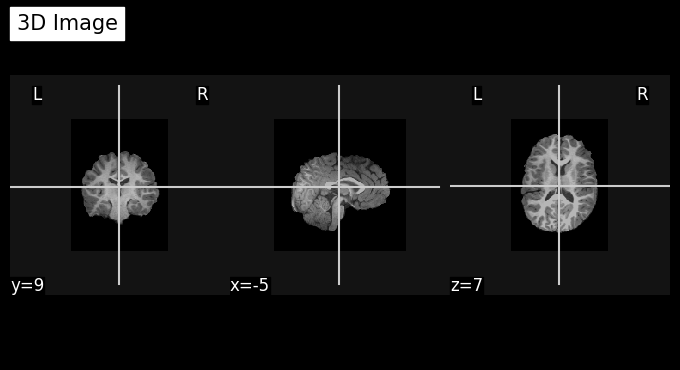

In [4]:
image_path = 'Preprocessed_Data/ABIDE_COMBINED/test/29864_prep.nii.gz'
img = nilearn.image.load_img(image_path)
data = img.get_fdata()
data_squeezed = np.squeeze(data)
img_squeezed = nib.Nifti1Image(data_squeezed, affine=img.affine)
plotting.plot_anat(img_squeezed, display_mode='ortho', title='3D Image')
plotting.show()

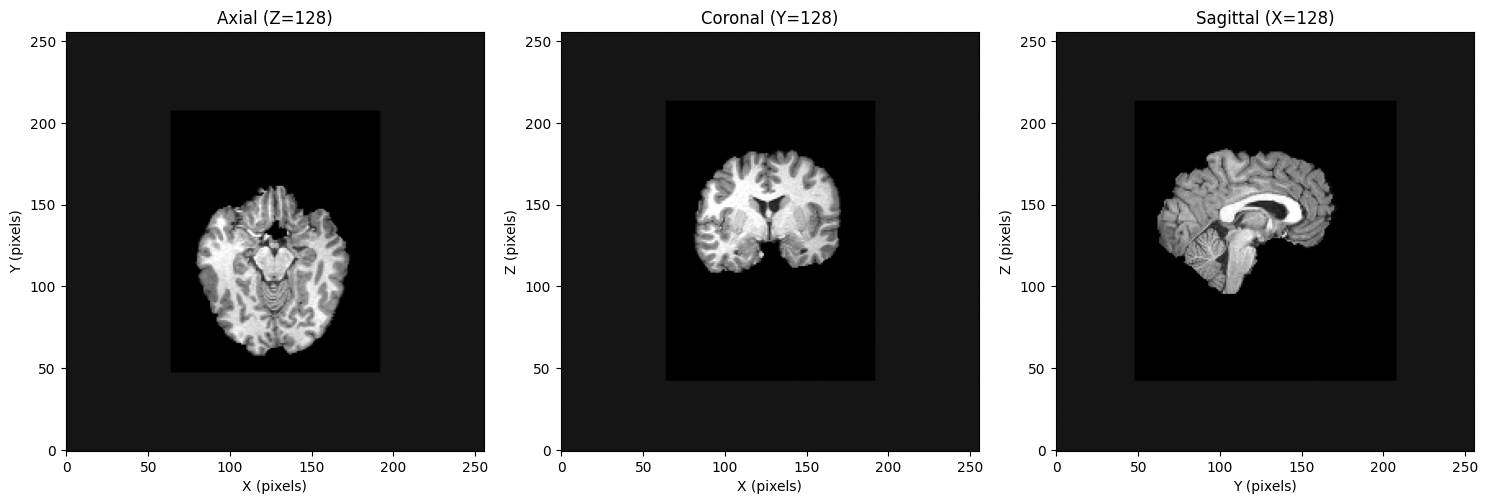

In [7]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Load and squeeze the image
img = nib.load('Preprocessed_Data/ABIDE_COMBINED/train/0050517_prep.nii.gz') #29864
data = np.squeeze(img.get_fdata())  # shape: (256, 256, 256)

# Select middle slices for axial, coronal, and sagittal views
mid_x = data.shape[0] // 2
mid_y = data.shape[1] // 2
mid_z = data.shape[2] // 2

# Plot using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial (Z slice)
axes[0].imshow(data[:, :, mid_z].T, cmap='gray', origin='lower')
axes[0].set_title(f'Axial (Z={mid_z})')
axes[0].set_xlabel('X (pixels)')
axes[0].set_ylabel('Y (pixels)')

# Coronal (Y slice)
axes[1].imshow(data[:, mid_y, :].T, cmap='gray', origin='lower')
axes[1].set_title(f'Coronal (Y={mid_y})')
axes[1].set_xlabel('X (pixels)')
axes[1].set_ylabel('Z (pixels)')

# Sagittal (X slice)
axes[2].imshow(data[mid_x, :, :].T, cmap='gray', origin='lower')
axes[2].set_title(f'Sagittal (X={mid_x})')
axes[2].set_xlabel('Y (pixels)')
axes[2].set_ylabel('Z (pixels)')

plt.tight_layout()
plt.show()


# Original Raw Data

## ABIDEI

In [14]:
folder_path = 'Original_Data/ABIDE1'
get_unique_image_shapes_with_paths_sorted(folder_path)


📦 Unique image shapes and file paths (sorted by voxel count):

Shape [160.0, 191.0, 90.0] (2750400 voxels):
  Original_Data/ABIDE1/UM_1/sub-0050291/anat/sub-0050291_T1w.nii.gz

Shape [155.0, 187.0, 96.0] (2782560 voxels):
  Original_Data/ABIDE1/UM_1/sub-0050343/anat/sub-0050343_T1w.nii.gz

Shape [163.0, 186.0, 94.0] (2849892 voxels):
  Original_Data/ABIDE1/UM_1/sub-0050302/anat/sub-0050302_T1w.nii.gz

Shape [106.0, 190.0, 147.0] (2960580 voxels):
  Original_Data/ABIDE1/UM_1/sub-0050283/anat/sub-0050283_T1w.nii.gz

Shape [180.0, 201.0, 83.0] (3002940 voxels):
  Original_Data/ABIDE1/UM_1/sub-0050345/anat/sub-0050345_T1w.nii.gz

Shape [173.0, 190.0, 95.0] (3122650 voxels):
  Original_Data/ABIDE1/UM_1/sub-0050300/anat/sub-0050300_T1w.nii.gz

Shape [168.0, 185.0, 101.0] (3139080 voxels):
  Original_Data/ABIDE1/UM_1/sub-0050336/anat/sub-0050336_T1w.nii.gz

Shape [171.0, 187.0, 99.0] (3165723 voxels):
  Original_Data/ABIDE1/UM_1/sub-0050358/anat/sub-0050358_T1w.nii.gz

Shape [169.0, 186.0, 1

/home/ejh2wy/.local/lib/python3.11/site-packages/nilearn/image/resampling.py:867: UserWarning: Casting data from int32 to float32
  return resample_img(


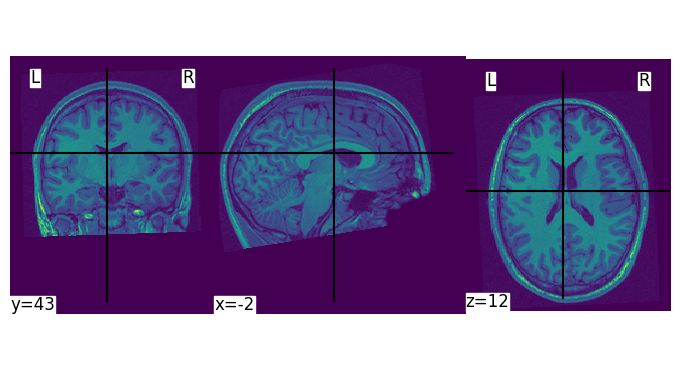

In [8]:
image_path = 'Original_Data/ABIDE1/USM/sub-0050517/anat/sub-0050517_T1w.nii.gz'
img = nilearn.image.load_img(image_path)
plotting.plot_img(image_path)

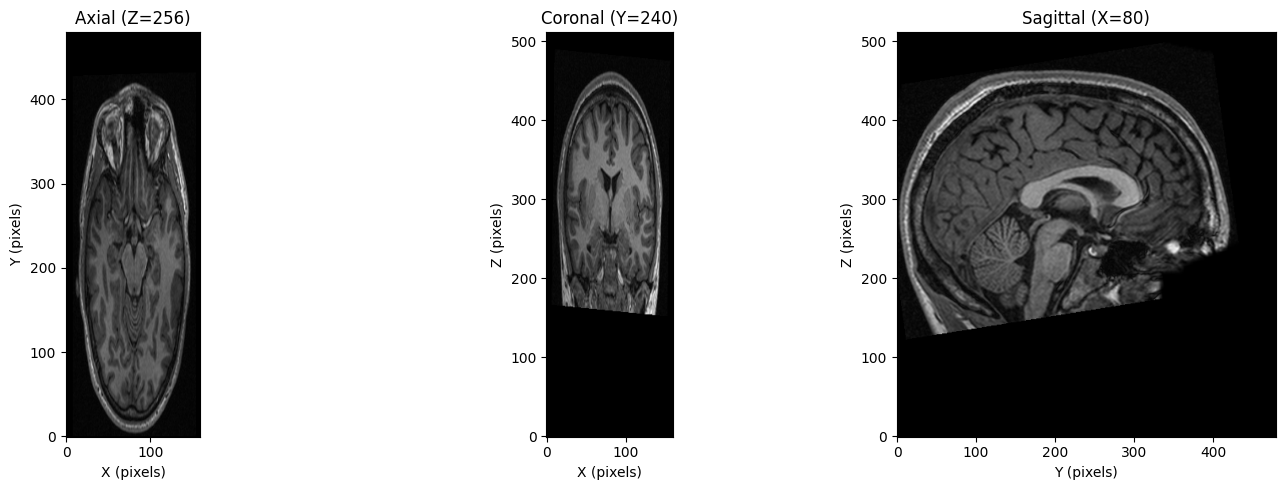

In [10]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Load and squeeze the image
img = nib.load('Original_Data/ABIDE1/USM/sub-0050517/anat/sub-0050517_T1w.nii.gz') #29864
data = np.squeeze(img.get_fdata())  # shape: (256, 256, 256)

# Select middle slices for axial, coronal, and sagittal views
mid_x = data.shape[0] // 2
mid_y = data.shape[1] // 2
mid_z = data.shape[2] // 2

# Plot using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial (Z slice)
axes[0].imshow(data[:, :, mid_z].T, cmap='gray', origin='lower')
axes[0].set_title(f'Axial (Z={mid_z})')
axes[0].set_xlabel('X (pixels)')
axes[0].set_ylabel('Y (pixels)')

# Coronal (Y slice)
axes[1].imshow(data[:, mid_y, :].T, cmap='gray', origin='lower')
axes[1].set_title(f'Coronal (Y={mid_y})')
axes[1].set_xlabel('X (pixels)')
axes[1].set_ylabel('Z (pixels)')

# Sagittal (X slice)
axes[2].imshow(data[mid_x, :, :].T, cmap='gray', origin='lower')
axes[2].set_title(f'Sagittal (X={mid_x})')
axes[2].set_xlabel('Y (pixels)')
axes[2].set_ylabel('Z (pixels)')

plt.tight_layout()
plt.show()


In [9]:
print(img.get_fdata().shape)
print(img.header)

(160, 480, 512)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'')
dim_info        : 0
dim             : [  3 160 480 512   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         1.1999999  0.5        0.5        1.         1.
  1.         1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.025304586
quatern_c       : 0.9996798
q

## ABIDEII

In [16]:
folder_path = 'Original_Data/ABIDE2'
get_unique_image_shapes_with_paths_sorted(folder_path)


 Unique image shapes and file paths (sorted by voxel count):

Shape [127.0, 194.0, 157.0] (3868166 voxels):
  Original_Data/ABIDE2/ABIDEII-NYU_1/sub-29213/ses-1/anat/sub-29213_ses-1_run-1_T1w.nii.gz

Shape [128.0, 192.0, 163.0] (4005888 voxels):
  Original_Data/ABIDE2/ABIDEII-NYU_2/sub-29158/ses-1/anat/sub-29158_ses-1_run-1_T1w.nii.gz

Shape [127.0, 208.0, 154.0] (4068064 voxels):
  Original_Data/ABIDE2/ABIDEII-NYU_1/sub-29230/ses-1/anat/sub-29230_ses-1_run-1_T1w.nii.gz

Shape [128.0, 199.0, 160.0] (4075520 voxels):
  Original_Data/ABIDE2/ABIDEII-NYU_2/sub-29164/ses-1/anat/sub-29164_ses-1_run-1_T1w.nii.gz

Shape [128.0, 210.0, 154.0] (4139520 voxels):
  Original_Data/ABIDE2/ABIDEII-NYU_2/sub-29173/ses-1/anat/sub-29173_ses-1_run-1_T1w.nii.gz

Shape [128.0, 199.0, 163.0] (4151936 voxels):
  Original_Data/ABIDE2/ABIDEII-NYU_1/sub-29227/ses-1/anat/sub-29227_ses-1_run-1_T1w.nii.gz

Shape [123.0, 211.0, 160.0] (4152480 voxels):
  Original_Data/ABIDE2/ABIDEII-NYU_1/sub-29238/ses-1/anat/sub-2

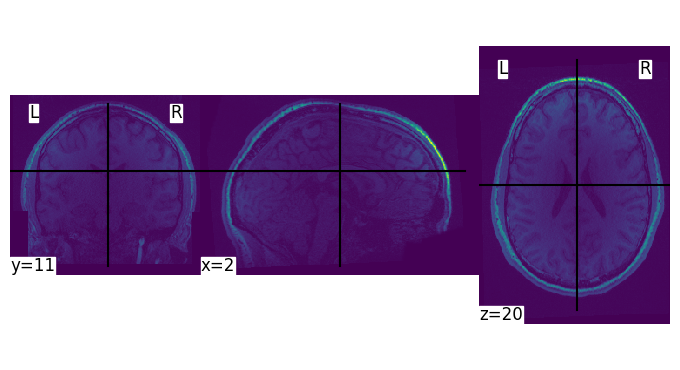

In [19]:
image_path = image_path = 'Original_Data/ABIDE2/ABIDEII-ONRC_2/sub-28705/ses-1/anat/sub-28705_ses-1_run-3_T1w.nii.gz'
img = nilearn.image.load_img(image_path)
plotting.plot_img(image_path)

In [ ]:
print(img.get_fdata().shape)
print(img.header)

# Preprocessed Data

## ABIDEI

In [17]:
folder_path = 'JustBrain_Data/ABIDE1'
get_unique_image_shapes_with_paths_sorted(folder_path)


 Unique image shapes and file paths (sorted by voxel count):

Shape [122.0, 152.0, 81.0] (1502064 voxels):
  JustBrain_Data/ABIDE1/sub-0050343/anat/sub-0050343_T1w.nii.gz

Shape [135.0, 159.0, 74.0] (1588410 voxels):
  JustBrain_Data/ABIDE1/sub-0050345/anat/sub-0050345_T1w.nii.gz

Shape [120.0, 141.0, 97.0] (1641240 voxels):
  JustBrain_Data/ABIDE1/sub-0050309/anat/sub-0050309_T1w.nii.gz

Shape [132.0, 154.0, 82.0] (1666896 voxels):
  JustBrain_Data/ABIDE1/sub-0050291/anat/sub-0050291_T1w.nii.gz

Shape [100.0, 159.0, 107.0] (1701300 voxels):
  JustBrain_Data/ABIDE1/sub-0050955/anat/sub-0050955_T1w.nii.gz

Shape [90.0, 158.0, 121.0] (1720620 voxels):
  JustBrain_Data/ABIDE1/sub-0050962/anat/sub-0050962_T1w.nii.gz

Shape [133.0, 154.0, 86.0] (1761452 voxels):
  JustBrain_Data/ABIDE1/sub-0050300/anat/sub-0050300_T1w.nii.gz

Shape [99.0, 151.0, 118.0] (1763982 voxels):
  JustBrain_Data/ABIDE1/sub-0050283/anat/sub-0050283_T1w.nii.gz

Shape [133.0, 151.0, 88.0] (1767304 voxels):
  JustBrain

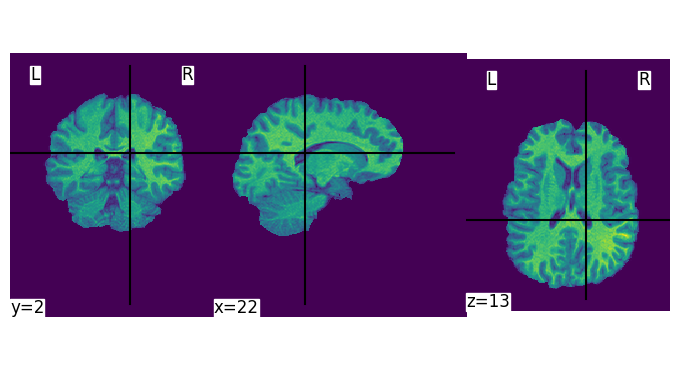

In [36]:
image_path = 'JustBrain_Data/ABIDE1/sub-0050490/anat/sub-0050490_T1w.nii.gz'
img = nilearn.image.load_img(image_path)
plotting.plot_img(image_path)

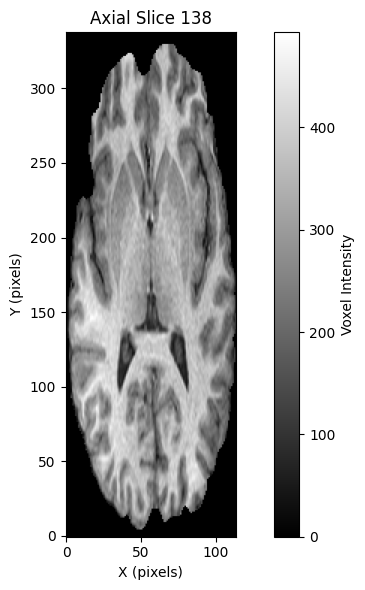

In [6]:
import matplotlib.pyplot as plt
image_path = 'JustBrain_Data/ABIDE1/sub-0050490/anat/sub-0050490_T1w.nii.gz'
img = nilearn.image.load_img(image_path)

img = crop_zero_planes(img)

data = img.get_fdata()

# Choose a slice to visualize (e.g., middle slice along the z-axis)
slice_index = data.shape[2] // 2  # middle slice
slice_2d = data[:, :, slice_index]

# Plot
plt.figure(figsize=(8, 6))
im = plt.imshow(slice_2d.T, cmap='gray', origin='lower')  # .T to orient correctly
plt.title(f'Axial Slice {slice_index}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
cbar = plt.colorbar(im)
cbar.set_label('Voxel Intensity')
plt.grid(False)
plt.tight_layout()
plt.show()

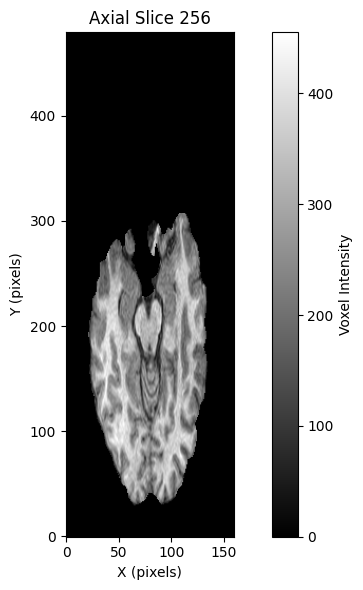

In [37]:
import matplotlib.pyplot as plt
# Load the NIfTI image
image_path = 'JustBrain_Data/ABIDE1/sub-0050490/anat/sub-0050490_T1w.nii.gz'
img = nib.load(image_path)
data = img.get_fdata()

# Choose a slice to visualize (e.g., middle slice along the z-axis)
slice_index = data.shape[2] // 2  # middle slice
slice_2d = data[:, :, slice_index]

# Plot
plt.figure(figsize=(8, 6))
im = plt.imshow(slice_2d.T, cmap='gray', origin='lower')  # .T to orient correctly
plt.title(f'Axial Slice {slice_index}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
cbar = plt.colorbar(im)
cbar.set_label('Voxel Intensity')
plt.grid(False)
plt.tight_layout()
plt.show()

In [38]:
print(img.get_fdata().shape)
print(img.header)

(160, 480, 512)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 16384
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 160 480 512   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.   1.2  0.5  0.5  1.   1.   1.   1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'2203.12-dirty 2024-02-01T16:17:47+00:00')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.011344402
quatern_c       : 0.9999

/home/ejh2wy/.local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



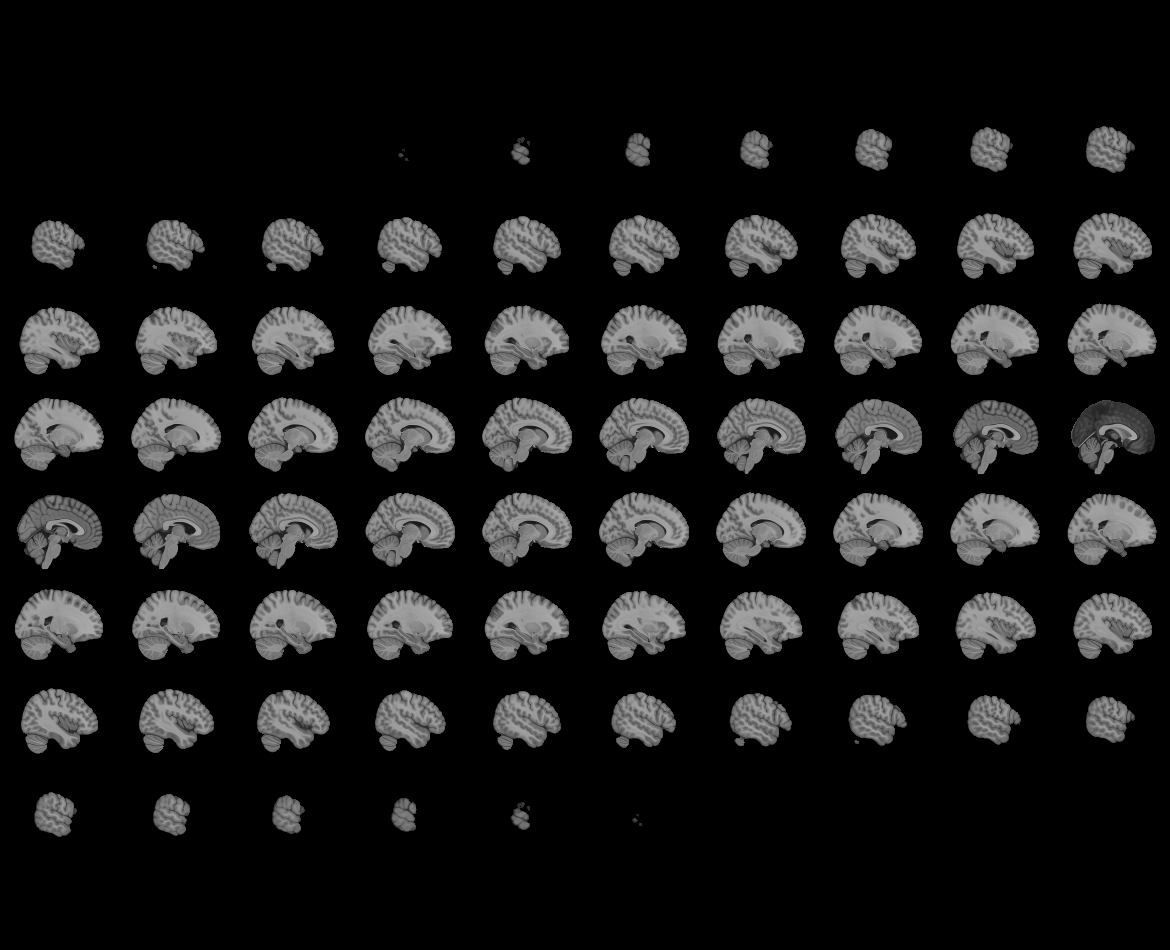
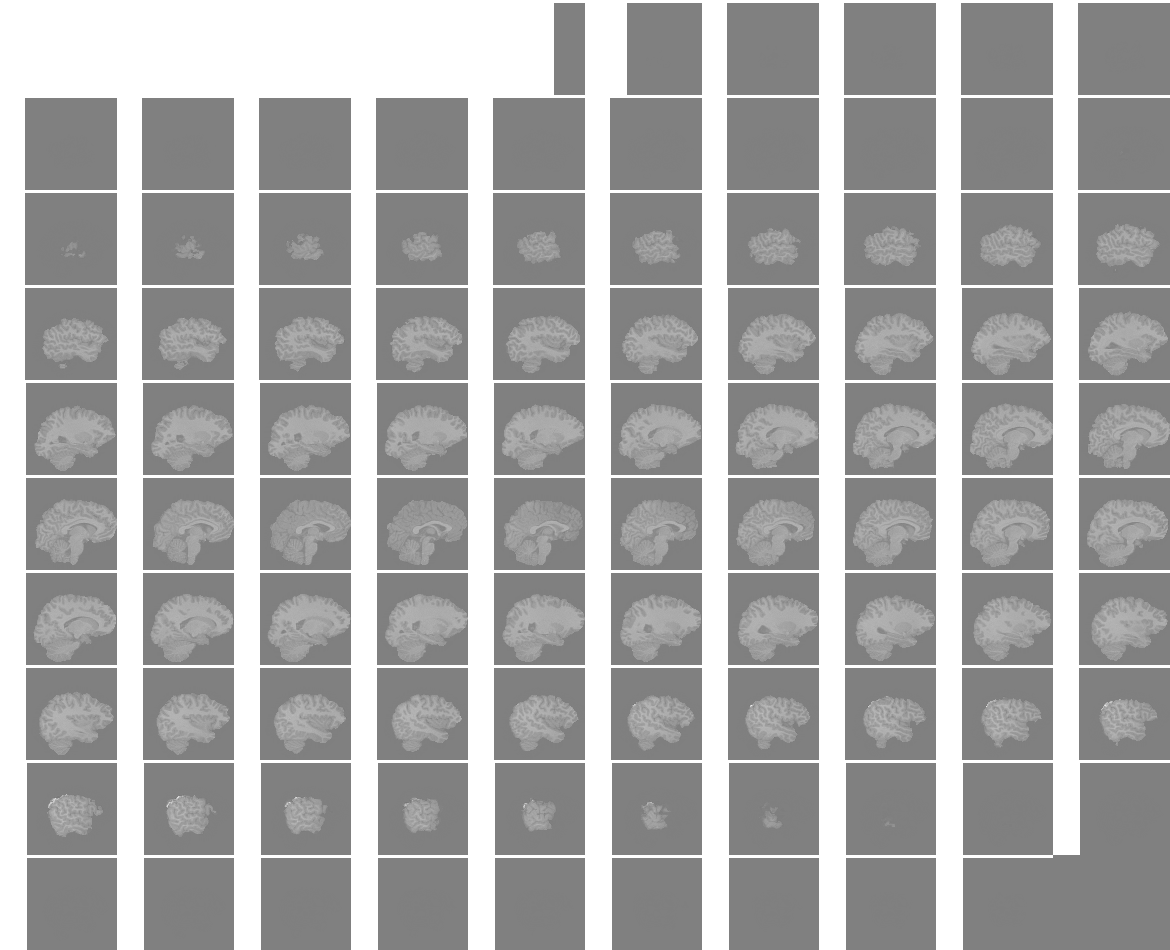

In [39]:
from nilearn import plotting, image

image_path = 'JustBrain_Data/ABIDE1/sub-0050490/anat/sub-0050490_T1w.nii.gz'#'JustBrain_Data/ABIDE1/sub-0050661/anat/sub-0050661_T1w.nii.gz'
img = image.load_img(image_path)

# Launch interactive 3D viewer in a Jupyter notebook or browser
plotting.view_img(img, threshold=None, cmap='gray')


## ABIDEII

In [18]:
folder_path = 'JustBrain_Data/ABIDE2'
get_unique_image_shapes_with_paths_sorted(folder_path)


 Unique image shapes and file paths (sorted by voxel count):

Shape [101.0, 167.0, 112.0] (1889104 voxels):
  JustBrain_Data/ABIDE2/sub-29183/anat/sub-29183_T1w.nii.gz

Shape [99.0, 160.0, 122.0] (1932480 voxels):
  JustBrain_Data/ABIDE2/sub-29182/anat/sub-29182_T1w.nii.gz

Shape [102.0, 161.0, 118.0] (1937796 voxels):
  JustBrain_Data/ABIDE2/sub-29171/anat/sub-29171_T1w.nii.gz

Shape [101.0, 156.0, 123.0] (1937988 voxels):
  JustBrain_Data/ABIDE2/sub-29241/anat/sub-29241_T1w.nii.gz
  JustBrain_Data/ABIDE2/sub-29245/anat/sub-29245_T1w.nii.gz

Shape [99.0, 158.0, 124.0] (1939608 voxels):
  JustBrain_Data/ABIDE2/sub-29194/anat/sub-29194_T1w.nii.gz

Shape [104.0, 163.0, 116.0] (1966432 voxels):
  JustBrain_Data/ABIDE2/sub-29173/anat/sub-29173_T1w.nii.gz

Shape [101.0, 159.0, 123.0] (1975257 voxels):
  JustBrain_Data/ABIDE2/sub-29213/anat/sub-29213_T1w.nii.gz

Shape [101.0, 157.0, 125.0] (1982125 voxels):
  JustBrain_Data/ABIDE2/sub-29166/anat/sub-29166_T1w.nii.gz

Shape [101.0, 161.0, 12

In [ ]:
image_path = 'JustBrain_Data/ABIDE2/sub-28675/anat/sub-28675_T1w.nii.gz'
img = nilearn.image.load_img(image_path)
plotting.plot_img(image_path)

In [5]:
# Took out UCLA because not in Garcia paper (and UCLA in ABIDEI)
# Removed JustBrain_Data/ABIDE2/sub-29503 - corrupt file